In [156]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from lightgbm.sklearn import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn import datasets, preprocessing

import os
from sklearn.metrics import mean_squared_error
from math import sqrt
import statsmodels.api as sm

# I. 데이터 수집 및 로드

In [157]:
train = pd.read_csv('./data/FIFA_train.csv')
test = pd.read_csv('./data/FIFA_test.csv')
submission = pd.read_csv('./data/submission.csv')

In [158]:
train.tail(3)

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
8929,16941,N. Fuentes,18,south america,2021,DF,right,1.0,47,64,2.0,50000.0
8930,16942,J. Milli,18,europe,2021,GK,right,1.0,47,65,1.0,50000.0
8931,16948,N. Christoffersson,19,europe,2020,ST,right,1.0,47,63,2.0,60000.0


In [159]:
test.tail(3)

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves
3825,16932,Y. Góez,18,south america,2021,MF,right,1.0,48,65,2.0
3826,16937,A. Kaltner,18,europe,2020,ST,right,1.0,47,61,2.0
3827,16943,K. Fujikawa,19,asia,2021,MF,right,1.0,47,61,2.0


In [160]:
submission.tail(3)

,id,value
3825,16932,0
3826,16937,0
3827,16943,0


# II. 데이터 분석

In [161]:
print(train.info())
print('\n','~'*90,'\n')
print(train.describe(),'\n\n\n',train.describe(include=['object']))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8932 entries, 0 to 8931
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                8932 non-null   int64  
 1   name              8932 non-null   object 
 2   age               8932 non-null   int64  
 3   continent         8932 non-null   object 
 4   contract_until    8932 non-null   object 
 5   position          8932 non-null   object 
 6   prefer_foot       8932 non-null   object 
 7   reputation        8932 non-null   float64
 8   stat_overall      8932 non-null   int64  
 9   stat_potential    8932 non-null   int64  
 10  stat_skill_moves  8932 non-null   float64
 11  value             8932 non-null   float64
dtypes: float64(3), int64(4), object(5)
memory usage: 837.5+ KB
None

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

                 id          age   reputation  stat_overall  stat_poten

In [162]:
print(train.isna().sum())
print('\n','~'*90,'\n')
print(test.isna().sum())

id                  0
name                0
age                 0
continent           0
contract_until      0
position            0
prefer_foot         0
reputation          0
stat_overall        0
stat_potential      0
stat_skill_moves    0
value               0
dtype: int64

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

id                  0
name                0
age                 0
continent           0
contract_until      0
position            0
prefer_foot         0
reputation          0
stat_overall        0
stat_potential      0
stat_skill_moves    0
dtype: int64


# III. 데이터 처리

결측치 없음, 제거할 컬럼도 없음!

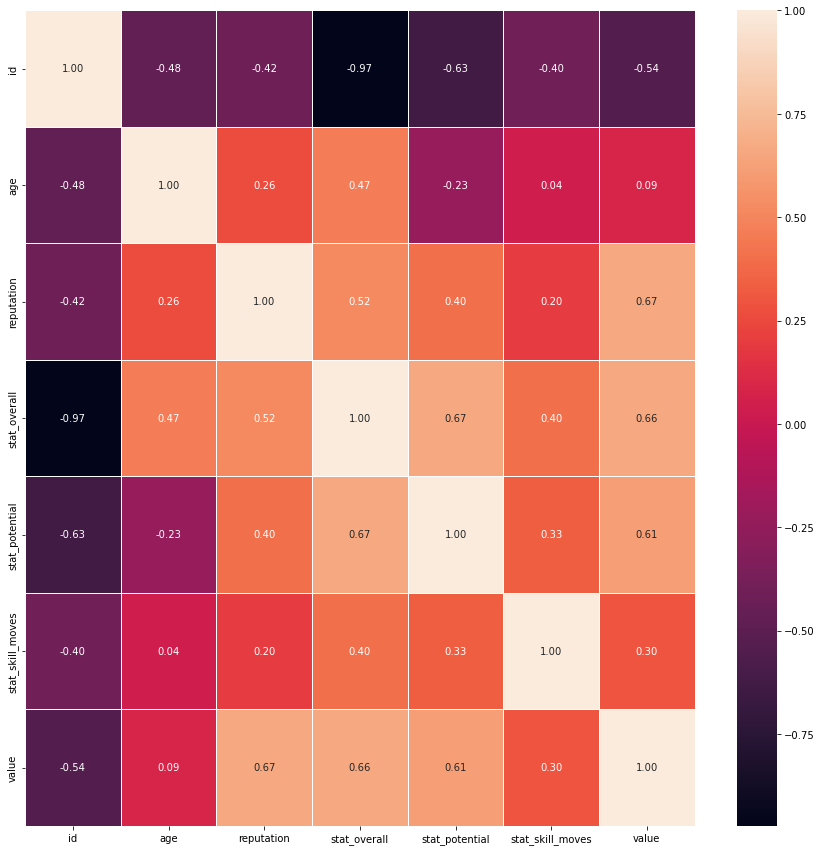

In [163]:
fig,ax = plt.subplots(figsize=(15, 15))
sns.heatmap(train.corr(), annot=True, linewidths=.5, fmt= '.2f',ax=ax)
plt.show()

In [164]:
train['contract_until'].unique()

array(['2021', '2020', '2019', '2023', '2022', '2024', 'Jun 30, 2019',
       '2026', 'Dec 31, 2018', '2018', '2025', 'Jun 30, 2020',
       'May 31, 2020', 'May 31, 2019', 'Jan 31, 2019', 'Jan 1, 2019',
       'Jan 12, 2019'], dtype=object)

In [165]:
def separate_year(train):
    for i in train.contract_until.unique():
        if len(i) > 4:
            x = i.split(' ')
            train['contract_until'] = train['contract_until'].replace(i,x[2])
        
    return train  
        
separate_year(train)

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,0,L. Messi,31,south america,2021,ST,left,5.0,94,94,4.0,110500000.0
1,3,De Gea,27,europe,2020,GK,right,4.0,91,93,1.0,72000000.0
2,7,L. Suárez,31,south america,2021,ST,right,5.0,91,91,3.0,80000000.0
3,8,Sergio Ramos,32,europe,2020,DF,right,4.0,91,91,3.0,51000000.0
4,9,J. Oblak,25,europe,2021,GK,right,3.0,90,93,1.0,68000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...
8927,16925,S. Adewusi,18,africa,2019,MF,right,1.0,48,63,3.0,60000.0
8928,16936,C. Ehlich,19,europe,2020,DF,right,1.0,47,59,2.0,40000.0
8929,16941,N. Fuentes,18,south america,2021,DF,right,1.0,47,64,2.0,50000.0
8930,16942,J. Milli,18,europe,2021,GK,right,1.0,47,65,1.0,50000.0


In [166]:
train = train.astype({'contract_until':'int16'})
train

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,0,L. Messi,31,south america,2021,ST,left,5.0,94,94,4.0,110500000.0
1,3,De Gea,27,europe,2020,GK,right,4.0,91,93,1.0,72000000.0
2,7,L. Suárez,31,south america,2021,ST,right,5.0,91,91,3.0,80000000.0
3,8,Sergio Ramos,32,europe,2020,DF,right,4.0,91,91,3.0,51000000.0
4,9,J. Oblak,25,europe,2021,GK,right,3.0,90,93,1.0,68000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...
8927,16925,S. Adewusi,18,africa,2019,MF,right,1.0,48,63,3.0,60000.0
8928,16936,C. Ehlich,19,europe,2020,DF,right,1.0,47,59,2.0,40000.0
8929,16941,N. Fuentes,18,south america,2021,DF,right,1.0,47,64,2.0,50000.0
8930,16942,J. Milli,18,europe,2021,GK,right,1.0,47,65,1.0,50000.0


In [167]:
def calcurate_year(train):
    for i in train.contract_until:
        train['remaining_contract_years'] = train['contract_until']-2018
        return train
calcurate_year(train)

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value,remaining_contract_years
0,0,L. Messi,31,south america,2021,ST,left,5.0,94,94,4.0,110500000.0,3
1,3,De Gea,27,europe,2020,GK,right,4.0,91,93,1.0,72000000.0,2
2,7,L. Suárez,31,south america,2021,ST,right,5.0,91,91,3.0,80000000.0,3
3,8,Sergio Ramos,32,europe,2020,DF,right,4.0,91,91,3.0,51000000.0,2
4,9,J. Oblak,25,europe,2021,GK,right,3.0,90,93,1.0,68000000.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8927,16925,S. Adewusi,18,africa,2019,MF,right,1.0,48,63,3.0,60000.0,1
8928,16936,C. Ehlich,19,europe,2020,DF,right,1.0,47,59,2.0,40000.0,2
8929,16941,N. Fuentes,18,south america,2021,DF,right,1.0,47,64,2.0,50000.0,3
8930,16942,J. Milli,18,europe,2021,GK,right,1.0,47,65,1.0,50000.0,3


In [168]:
train.contract_until.value_counts()

2019    2899
2021    2308
2020    2051
2022     761
2023     506
2018     391
2024      12
2025       3
2026       1
Name: contract_until, dtype: int64

In [169]:
train.remaining_contract_years.value_counts()

1    2899
3    2308
2    2051
4     761
5     506
0     391
6      12
7       3
8       1
Name: remaining_contract_years, dtype: int64

### one-hot encoding

In [170]:
dum_position = pd.get_dummies(train['position'])
print(dum_position,'\n','~'*90,'\n')
dum_continent = pd.get_dummies(train['continent'])
print(dum_continent,'\n','~'*90,'\n')
#dum_contract_until = pd.get_dummies(train['contract_until'])
#print(dum_contract_until,'\n','~'*90,'\n')
dum_prefer_foot = pd.get_dummies(train['prefer_foot'])
print(dum_prefer_foot)

      DF  GK  MF  ST
0      0   0   0   1
1      0   1   0   0
2      0   0   0   1
3      1   0   0   0
4      0   1   0   0
...   ..  ..  ..  ..
8927   0   0   1   0
8928   1   0   0   0
8929   1   0   0   0
8930   0   1   0   0
8931   0   0   0   1

[8932 rows x 4 columns] 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

      africa  asia  europe  oceania  south america
0          0     0       0        0              1
1          0     0       1        0              0
2          0     0       0        0              1
3          0     0       1        0              0
4          0     0       1        0              0
...      ...   ...     ...      ...            ...
8927       1     0       0        0              0
8928       0     0       1        0              0
8929       0     0       0        0              1
8930       0     0       1        0              0
8931       0     0       1        0              0

[8932 rows x 5 

In [171]:
train_numeric = train.drop(['contract_until','prefer_foot','continent','position','name','value'],axis=1)
train_numeric

,id,age,reputation,stat_overall,stat_potential,stat_skill_moves,remaining_contract_years
0,0,31,5.0,94,94,4.0,3
1,3,27,4.0,91,93,1.0,2
2,7,31,5.0,91,91,3.0,3
3,8,32,4.0,91,91,3.0,2
4,9,25,3.0,90,93,1.0,3
...,...,...,...,...,...,...,...
8927,16925,18,1.0,48,63,3.0,1
8928,16936,19,1.0,47,59,2.0,2
8929,16941,18,1.0,47,64,2.0,3
8930,16942,18,1.0,47,65,1.0,3


In [172]:
ohe_train = pd.concat([train_numeric,dum_prefer_foot,dum_continent,dum_position],axis=1)
ohe_train

,id,age,reputation,stat_overall,stat_potential,stat_skill_moves,remaining_contract_years,left,right,africa,asia,europe,oceania,south america,DF,GK,MF,ST
0,0,31,5.0,94,94,4.0,3,1,0,0,0,0,0,1,0,0,0,1
1,3,27,4.0,91,93,1.0,2,0,1,0,0,1,0,0,0,1,0,0
2,7,31,5.0,91,91,3.0,3,0,1,0,0,0,0,1,0,0,0,1
3,8,32,4.0,91,91,3.0,2,0,1,0,0,1,0,0,1,0,0,0
4,9,25,3.0,90,93,1.0,3,0,1,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8927,16925,18,1.0,48,63,3.0,1,0,1,1,0,0,0,0,0,0,1,0
8928,16936,19,1.0,47,59,2.0,2,0,1,0,0,1,0,0,1,0,0,0
8929,16941,18,1.0,47,64,2.0,3,0,1,0,0,0,0,1,1,0,0,0
8930,16942,18,1.0,47,65,1.0,3,0,1,0,0,1,0,0,0,1,0,0


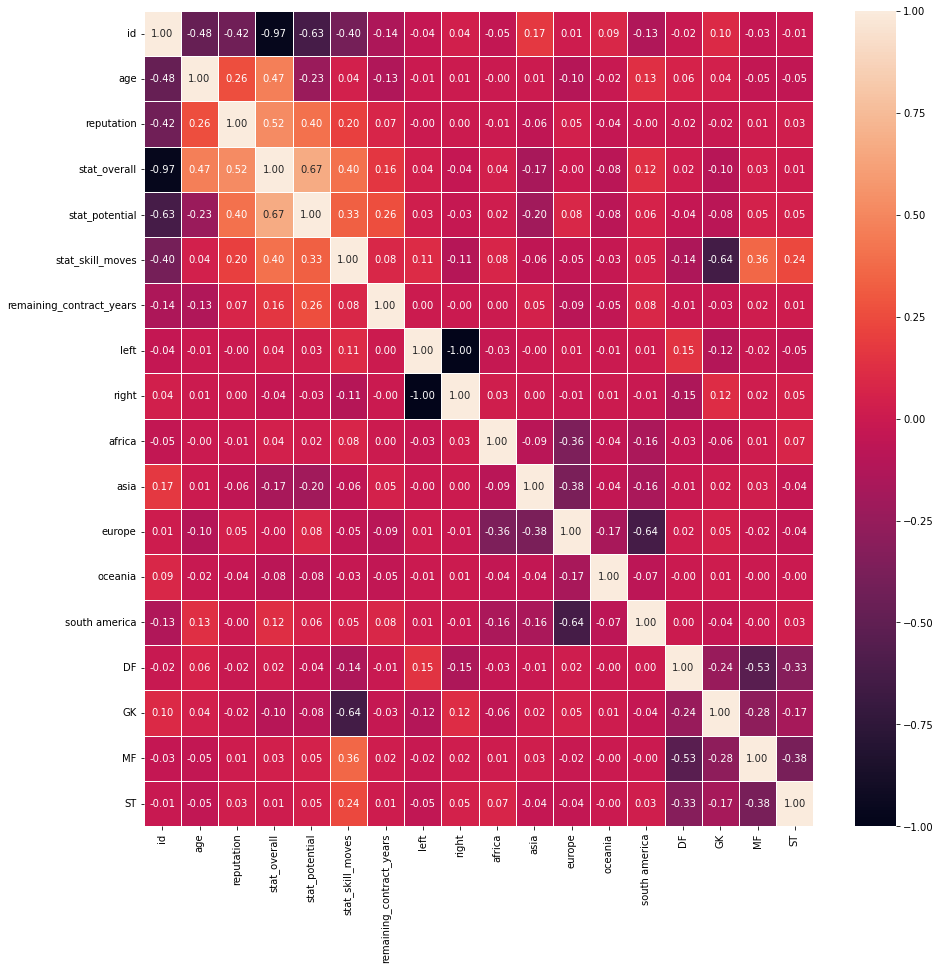

In [173]:
fig,ax = plt.subplots(figsize=(15, 15))
sns.heatmap(ohe_train.corr(), annot=True, linewidths=.5, fmt= '.2f',ax=ax)
plt.show()

# IV. 모델링

## 머신러닝

In [174]:
X = ohe_train
y = train['value']

In [175]:
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.2, random_state=42)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(7145, 18) (1787, 18) (7145,) (1787,)


### scaler

In [176]:
'''
scaler = MinMaxScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
#ohe_test_scaled = scaler.transform(ohe_test)


ohe_train_scaled
'''


'\nscaler = MinMaxScaler()\n\nscaler.fit(X_train)\n\nX_train_scaled = scaler.transform(X_train)\n#ohe_test_scaled = scaler.transform(ohe_test)\n\n\nohe_train_scaled\n'

In [177]:
LGBM_reg =LGBMRegressor()

LGBM_reg.fit(X_train,y_train)

pred_train = LGBM_reg.predict(X_train)
pred_val = LGBM_reg.predict(X_val)

mse_train = mean_squared_error(y_train, pred_train)
mse_val = mean_squared_error(y_val, pred_val)

print(f'mse train: {mse_train} \n\nmse validation: {mse_val}')

mse train: 284138798916.8734 

mse validation: 2337409613287.9243


## 딥러닝

In [178]:
import tensorflow as tf
from tensorflow.keras import datasets, utils
from tensorflow.keras import models, layers, activations, initializers, losses, optimizers, metrics
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau

In [179]:
InputFeature = ohe_train[['reputation','stat_overall','stat_potential']]
Label = train['value']

In [180]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

'''
0 = all messages are logged (default behavior)
1 = INFO messages are not printed
2 = INFO and WARNING messages are not printed
3 = INFO, WARNING, and ERROR messages are not printed
'''

'\n0 = all messages are logged (default behavior)\n1 = INFO messages are not printed\n2 = INFO and WARNING messages are not printed\n3 = INFO, WARNING, and ERROR messages are not printed\n'

In [181]:
model = models.Sequential() 

model.add(layers.Dense(input_dim=3, units=64, activation=None, kernel_initializer=initializers.he_uniform())) 
# model.add(layers.BatchNormalization()) # Use this line as if needed
model.add(layers.Activation('elu')) # elu or relu (or layers.ELU / layers.LeakyReLU)

model.add(layers.Dense(units=64, activation=None, kernel_initializer=initializers.he_uniform())) 
model.add(layers.Activation('elu'))

model.add(layers.Dense(units=32, activation=None, kernel_initializer=initializers.he_uniform())) 
model.add(layers.Activation('elu'))
model.add(layers.Dropout(rate=0.4))

model.add(layers.Dense(units=1, activation=None)) 

In [182]:
model.compile(optimizer=optimizers.Adam(), 
              loss=losses.mean_squared_error, 
              metrics=[metrics.mean_squared_error]) 

In [183]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 64)                256       
                                                                 
 activation_18 (Activation)  (None, 64)                0         
                                                                 
 dense_25 (Dense)            (None, 64)                4160      
                                                                 
 activation_19 (Activation)  (None, 64)                0         
                                                                 
 dense_26 (Dense)            (None, 32)                2080      
                                                                 
 activation_20 (Activation)  (None, 32)                0         
                                                                 
 dropout_6 (Dropout)         (None, 32)               

In [192]:
# Call-back 함수
# CheckPoint: Epoch 마다 validation 성능을 검증하여, best performance 일 경우 저장
CP = ModelCheckpoint(filepath='-{epoch:03d}-{loss:.4f}-{accuracy:.4f}.hdf5',
            monitor='loss', verbose=1, save_best_only=True, mode='min')

# Learning Rate 줄여나가기
LR = ReduceLROnPlateau(monitor='loss',factor=0.8,patience=3, verbose=1, min_lr=1e-8)

CALLBACK = [LR] #[CP, LR]

In [193]:
history = model.fit(InputFeature,Label, batch_size=10, epochs=1000,shuffle=True,callbacks=CALLBACK, validation_split=0.3)


Epoch 1/1000
626/626 [==============================] - 0s 549us/step - loss: 43460543381504.0000 - mean_squared_error: 43460543381504.0000 - val_loss: 10032223617024.0000 - val_mean_squared_error: 10032223617024.0000 - lr: 0.0010
Epoch 2/1000
626/626 [==============================] - 0s 523us/step - loss: 43202857926656.0000 - mean_squared_error: 43202857926656.0000 - val_loss: 10205292134400.0000 - val_mean_squared_error: 10205292134400.0000 - lr: 0.0010
Epoch 3/1000
626/626 [==============================] - 0s 531us/step - loss: 43440888872960.0000 - mean_squared_error: 43440888872960.0000 - val_loss: 9403390492672.0000 - val_mean_squared_error: 9403390492672.0000 - lr: 0.0010
Epoch 4/1000
626/626 [==============================] - 0s 527us/step - loss: 43309070286848.0000 - mean_squared_error: 43309070286848.0000 - val_loss: 10225519165440.0000 - val_mean_squared_error: 10225519165440.0000 - lr: 0.0010
Epoch 5/1000
594/626 [===========================>..] - ETA: 0s - loss: 446728

Epoch 32/1000
626/626 [==============================] - 0s 532us/step - loss: 43304750153728.0000 - mean_squared_error: 43304750153728.0000 - val_loss: 9876530003968.0000 - val_mean_squared_error: 9876530003968.0000 - lr: 3.2768e-04
Epoch 33/1000
626/626 [==============================] - 0s 532us/step - loss: 43268289069056.0000 - mean_squared_error: 43268289069056.0000 - val_loss: 9725522477056.0000 - val_mean_squared_error: 9725522477056.0000 - lr: 3.2768e-04
Epoch 34/1000
626/626 [==============================] - 0s 522us/step - loss: 42580683259904.0000 - mean_squared_error: 42580683259904.0000 - val_loss: 10130511888384.0000 - val_mean_squared_error: 10130511888384.0000 - lr: 3.2768e-04
Epoch 35/1000
626/626 [==============================] - 0s 526us/step - loss: 42620868886528.0000 - mean_squared_error: 42620868886528.0000 - val_loss: 10047109201920.0000 - val_mean_squared_error: 10047109201920.0000 - lr: 3.2768e-04
Epoch 36/1000
626/626 [==============================] - 0s 

626/626 [==============================] - 0s 524us/step - loss: 42493764698112.0000 - mean_squared_error: 42493764698112.0000 - val_loss: 9993799598080.0000 - val_mean_squared_error: 9993799598080.0000 - lr: 5.4976e-05
Epoch 61/1000
626/626 [==============================] - 0s 524us/step - loss: 42625704919040.0000 - mean_squared_error: 42625704919040.0000 - val_loss: 9984049938432.0000 - val_mean_squared_error: 9984049938432.0000 - lr: 5.4976e-05
Epoch 62/1000
607/626 [============================>.] - ETA: 0s - loss: 42538912186368.0000 - mean_squared_error: 42538912186368.0000
Epoch 62: ReduceLROnPlateau reducing learning rate to 4.398046876303852e-05.
626/626 [==============================] - 0s 522us/step - loss: 42868278296576.0000 - mean_squared_error: 42868278296576.0000 - val_loss: 9951829295104.0000 - val_mean_squared_error: 9951829295104.0000 - lr: 5.4976e-05
Epoch 63/1000
626/626 [==============================] - 0s 529us/step - loss: 42733993459712.0000 - mean_squared_

Epoch 89/1000
626/626 [==============================] - 0s 521us/step - loss: 42924117065728.0000 - mean_squared_error: 42924117065728.0000 - val_loss: 10016157335552.0000 - val_mean_squared_error: 10016157335552.0000 - lr: 1.1529e-05
Epoch 90/1000
626/626 [==============================] - 0s 524us/step - loss: 43073895661568.0000 - mean_squared_error: 43073895661568.0000 - val_loss: 10008248975360.0000 - val_mean_squared_error: 10008248975360.0000 - lr: 1.1529e-05
Epoch 91/1000
604/626 [===========================>..] - ETA: 0s - loss: 43510166192128.0000 - mean_squared_error: 43510166192128.0000
Epoch 91: ReduceLROnPlateau reducing learning rate to 9.223372762789951e-06.
626/626 [==============================] - 0s 524us/step - loss: 42778679574528.0000 - mean_squared_error: 42778679574528.0000 - val_loss: 10007649189888.0000 - val_mean_squared_error: 10007649189888.0000 - lr: 1.1529e-05
Epoch 92/1000
626/626 [==============================] - 0s 524us/step - loss: 42724908597248.

Epoch 117/1000
626/626 [==============================] - 0s 525us/step - loss: 42685222092800.0000 - mean_squared_error: 42685222092800.0000 - val_loss: 9987647602688.0000 - val_mean_squared_error: 9987647602688.0000 - lr: 1.5474e-06
Epoch 118/1000
626/626 [==============================] - 0s 521us/step - loss: 42765446545408.0000 - mean_squared_error: 42765446545408.0000 - val_loss: 9987502899200.0000 - val_mean_squared_error: 9987502899200.0000 - lr: 1.5474e-06
Epoch 119/1000
607/626 [============================>.] - ETA: 0s - loss: 42509875019776.0000 - mean_squared_error: 42509875019776.0000
Epoch 119: ReduceLROnPlateau reducing learning rate to 1.2379403415252455e-06.
626/626 [==============================] - 0s 520us/step - loss: 42807469277184.0000 - mean_squared_error: 42807469277184.0000 - val_loss: 9987015311360.0000 - val_mean_squared_error: 9987015311360.0000 - lr: 1.5474e-06
Epoch 120/1000
626/626 [==============================] - 0s 525us/step - loss: 42959307276288.

626/626 [==============================] - 0s 521us/step - loss: 43047727398912.0000 - mean_squared_error: 43047727398912.0000 - val_loss: 9987697934336.0000 - val_mean_squared_error: 9987697934336.0000 - lr: 2.0769e-07
Epoch 145/1000
626/626 [==============================] - 0s 520us/step - loss: 43019566841856.0000 - mean_squared_error: 43019566841856.0000 - val_loss: 9987619291136.0000 - val_mean_squared_error: 9987619291136.0000 - lr: 2.0769e-07
Epoch 146/1000
604/626 [===========================>..] - ETA: 0s - loss: 42814310187008.0000 - mean_squared_error: 42814310187008.0000
Epoch 146: ReduceLROnPlateau reducing learning rate to 1.6615351796644973e-07.
626/626 [==============================] - 0s 524us/step - loss: 42610055970816.0000 - mean_squared_error: 42610055970816.0000 - val_loss: 9987839492096.0000 - val_mean_squared_error: 9987839492096.0000 - lr: 2.0769e-07
Epoch 147/1000
626/626 [==============================] - 0s 522us/step - loss: 42524114681856.0000 - mean_squ

626/626 [==============================] - 0s 523us/step - loss: 42654532370432.0000 - mean_squared_error: 42654532370432.0000 - val_loss: 9988949934080.0000 - val_mean_squared_error: 9988949934080.0000 - lr: 2.7876e-08
Epoch 172/1000
626/626 [==============================] - 0s 521us/step - loss: 42831842377728.0000 - mean_squared_error: 42831842377728.0000 - val_loss: 9988949934080.0000 - val_mean_squared_error: 9988949934080.0000 - lr: 2.7876e-08
Epoch 173/1000
606/626 [============================>.] - ETA: 0s - loss: 43371095654400.0000 - mean_squared_error: 43371095654400.0000
Epoch 173: ReduceLROnPlateau reducing learning rate to 2.2300748980796928e-08.
626/626 [==============================] - 0s 522us/step - loss: 42978441691136.0000 - mean_squared_error: 42978441691136.0000 - val_loss: 9988947836928.0000 - val_mean_squared_error: 9988947836928.0000 - lr: 2.7876e-08
Epoch 174/1000
626/626 [==============================] - 0s 524us/step - loss: 42408435777536.0000 - mean_squ

Epoch 202/1000
626/626 [==============================] - 0s 533us/step - loss: 43017025093632.0000 - mean_squared_error: 43017025093632.0000 - val_loss: 9988954128384.0000 - val_mean_squared_error: 9988954128384.0000 - lr: 1.0000e-08
Epoch 203/1000
626/626 [==============================] - 0s 518us/step - loss: 42701454049280.0000 - mean_squared_error: 42701454049280.0000 - val_loss: 9988954128384.0000 - val_mean_squared_error: 9988954128384.0000 - lr: 1.0000e-08
Epoch 204/1000
626/626 [==============================] - 0s 521us/step - loss: 42592435699712.0000 - mean_squared_error: 42592435699712.0000 - val_loss: 9988954128384.0000 - val_mean_squared_error: 9988954128384.0000 - lr: 1.0000e-08
Epoch 205/1000
626/626 [==============================] - 0s 524us/step - loss: 42786636169216.0000 - mean_squared_error: 42786636169216.0000 - val_loss: 9988957274112.0000 - val_mean_squared_error: 9988957274112.0000 - lr: 1.0000e-08
Epoch 206/1000
626/626 [==============================] - 0s

Epoch 237/1000
626/626 [==============================] - 0s 511us/step - loss: 42914289811456.0000 - mean_squared_error: 42914289811456.0000 - val_loss: 9988957274112.0000 - val_mean_squared_error: 9988957274112.0000 - lr: 1.0000e-08
Epoch 238/1000
626/626 [==============================] - 0s 501us/step - loss: 43101842309120.0000 - mean_squared_error: 43101842309120.0000 - val_loss: 9988959371264.0000 - val_mean_squared_error: 9988959371264.0000 - lr: 1.0000e-08
Epoch 239/1000
626/626 [==============================] - 0s 503us/step - loss: 42664040857600.0000 - mean_squared_error: 42664040857600.0000 - val_loss: 9988959371264.0000 - val_mean_squared_error: 9988959371264.0000 - lr: 1.0000e-08
Epoch 240/1000
626/626 [==============================] - 0s 505us/step - loss: 42895184756736.0000 - mean_squared_error: 42895184756736.0000 - val_loss: 9988959371264.0000 - val_mean_squared_error: 9988959371264.0000 - lr: 1.0000e-08
Epoch 241/1000
626/626 [==============================] - 0s

Epoch 272/1000
626/626 [==============================] - 0s 494us/step - loss: 43029670920192.0000 - mean_squared_error: 43029670920192.0000 - val_loss: 9988959371264.0000 - val_mean_squared_error: 9988959371264.0000 - lr: 1.0000e-08
Epoch 273/1000
626/626 [==============================] - 0s 495us/step - loss: 42807708352512.0000 - mean_squared_error: 42807708352512.0000 - val_loss: 9988959371264.0000 - val_mean_squared_error: 9988959371264.0000 - lr: 1.0000e-08
Epoch 274/1000
626/626 [==============================] - 0s 492us/step - loss: 42838247079936.0000 - mean_squared_error: 42838247079936.0000 - val_loss: 9988960419840.0000 - val_mean_squared_error: 9988960419840.0000 - lr: 1.0000e-08
Epoch 275/1000
626/626 [==============================] - 0s 497us/step - loss: 42528363511808.0000 - mean_squared_error: 42528363511808.0000 - val_loss: 9988960419840.0000 - val_mean_squared_error: 9988960419840.0000 - lr: 1.0000e-08
Epoch 276/1000
626/626 [==============================] - 0s

Epoch 307/1000
626/626 [==============================] - 0s 530us/step - loss: 42675604553728.0000 - mean_squared_error: 42675604553728.0000 - val_loss: 9988959371264.0000 - val_mean_squared_error: 9988959371264.0000 - lr: 1.0000e-08
Epoch 308/1000
626/626 [==============================] - 0s 534us/step - loss: 42729031598080.0000 - mean_squared_error: 42729031598080.0000 - val_loss: 9988960419840.0000 - val_mean_squared_error: 9988960419840.0000 - lr: 1.0000e-08
Epoch 309/1000
626/626 [==============================] - 0s 530us/step - loss: 42683481456640.0000 - mean_squared_error: 42683481456640.0000 - val_loss: 9988959371264.0000 - val_mean_squared_error: 9988959371264.0000 - lr: 1.0000e-08
Epoch 310/1000
626/626 [==============================] - 0s 541us/step - loss: 42709892988928.0000 - mean_squared_error: 42709892988928.0000 - val_loss: 9988959371264.0000 - val_mean_squared_error: 9988959371264.0000 - lr: 1.0000e-08
Epoch 311/1000
626/626 [==============================] - 0s

Epoch 342/1000
626/626 [==============================] - 0s 527us/step - loss: 42882895446016.0000 - mean_squared_error: 42882895446016.0000 - val_loss: 9988957274112.0000 - val_mean_squared_error: 9988957274112.0000 - lr: 1.0000e-08
Epoch 343/1000
626/626 [==============================] - 0s 567us/step - loss: 42792587886592.0000 - mean_squared_error: 42792587886592.0000 - val_loss: 9988957274112.0000 - val_mean_squared_error: 9988957274112.0000 - lr: 1.0000e-08
Epoch 344/1000
626/626 [==============================] - 0s 526us/step - loss: 42926629453824.0000 - mean_squared_error: 42926625259520.0000 - val_loss: 9988957274112.0000 - val_mean_squared_error: 9988957274112.0000 - lr: 1.0000e-08
Epoch 345/1000
626/626 [==============================] - 0s 526us/step - loss: 42833050337280.0000 - mean_squared_error: 42833050337280.0000 - val_loss: 9988957274112.0000 - val_mean_squared_error: 9988957274112.0000 - lr: 1.0000e-08
Epoch 346/1000
626/626 [==============================] - 0s

Epoch 377/1000
626/626 [==============================] - 0s 521us/step - loss: 42657338359808.0000 - mean_squared_error: 42657338359808.0000 - val_loss: 9988960419840.0000 - val_mean_squared_error: 9988960419840.0000 - lr: 1.0000e-08
Epoch 378/1000
626/626 [==============================] - 0s 535us/step - loss: 42809792921600.0000 - mean_squared_error: 42809792921600.0000 - val_loss: 9988960419840.0000 - val_mean_squared_error: 9988960419840.0000 - lr: 1.0000e-08
Epoch 379/1000
626/626 [==============================] - 0s 530us/step - loss: 42833528487936.0000 - mean_squared_error: 42833528487936.0000 - val_loss: 9988960419840.0000 - val_mean_squared_error: 9988960419840.0000 - lr: 1.0000e-08
Epoch 380/1000
626/626 [==============================] - 0s 524us/step - loss: 42778633437184.0000 - mean_squared_error: 42778633437184.0000 - val_loss: 9988960419840.0000 - val_mean_squared_error: 9988960419840.0000 - lr: 1.0000e-08
Epoch 381/1000
626/626 [==============================] - 0s

Epoch 412/1000
626/626 [==============================] - 0s 528us/step - loss: 42757456396288.0000 - mean_squared_error: 42757456396288.0000 - val_loss: 9988964614144.0000 - val_mean_squared_error: 9988964614144.0000 - lr: 1.0000e-08
Epoch 413/1000
626/626 [==============================] - 0s 522us/step - loss: 42718839439360.0000 - mean_squared_error: 42718839439360.0000 - val_loss: 9988964614144.0000 - val_mean_squared_error: 9988964614144.0000 - lr: 1.0000e-08
Epoch 414/1000
626/626 [==============================] - 0s 529us/step - loss: 42656700825600.0000 - mean_squared_error: 42656700825600.0000 - val_loss: 9988964614144.0000 - val_mean_squared_error: 9988964614144.0000 - lr: 1.0000e-08
Epoch 415/1000
626/626 [==============================] - 0s 528us/step - loss: 42832278585344.0000 - mean_squared_error: 42832278585344.0000 - val_loss: 9988963565568.0000 - val_mean_squared_error: 9988963565568.0000 - lr: 1.0000e-08
Epoch 416/1000
626/626 [==============================] - 0s

Epoch 447/1000
626/626 [==============================] - 0s 549us/step - loss: 42758412697600.0000 - mean_squared_error: 42758412697600.0000 - val_loss: 9988966711296.0000 - val_mean_squared_error: 9988966711296.0000 - lr: 1.0000e-08
Epoch 448/1000
626/626 [==============================] - 0s 542us/step - loss: 43127691804672.0000 - mean_squared_error: 43127691804672.0000 - val_loss: 9988966711296.0000 - val_mean_squared_error: 9988966711296.0000 - lr: 1.0000e-08
Epoch 449/1000
626/626 [==============================] - 0s 519us/step - loss: 43023668871168.0000 - mean_squared_error: 43023668871168.0000 - val_loss: 9988965662720.0000 - val_mean_squared_error: 9988965662720.0000 - lr: 1.0000e-08
Epoch 450/1000
626/626 [==============================] - 0s 529us/step - loss: 42901040005120.0000 - mean_squared_error: 42901040005120.0000 - val_loss: 9988966711296.0000 - val_mean_squared_error: 9988966711296.0000 - lr: 1.0000e-08
Epoch 451/1000
626/626 [==============================] - 0s

Epoch 482/1000
626/626 [==============================] - 0s 528us/step - loss: 42848065945600.0000 - mean_squared_error: 42848065945600.0000 - val_loss: 9988968808448.0000 - val_mean_squared_error: 9988968808448.0000 - lr: 1.0000e-08
Epoch 483/1000
626/626 [==============================] - 0s 525us/step - loss: 42679261986816.0000 - mean_squared_error: 42679261986816.0000 - val_loss: 9988968808448.0000 - val_mean_squared_error: 9988968808448.0000 - lr: 1.0000e-08
Epoch 484/1000
626/626 [==============================] - 0s 528us/step - loss: 42653546708992.0000 - mean_squared_error: 42653546708992.0000 - val_loss: 9988968808448.0000 - val_mean_squared_error: 9988968808448.0000 - lr: 1.0000e-08
Epoch 485/1000
626/626 [==============================] - 0s 524us/step - loss: 42619535097856.0000 - mean_squared_error: 42619535097856.0000 - val_loss: 9988968808448.0000 - val_mean_squared_error: 9988968808448.0000 - lr: 1.0000e-08
Epoch 486/1000
626/626 [==============================] - 0s

Epoch 517/1000
626/626 [==============================] - 0s 525us/step - loss: 42599419215872.0000 - mean_squared_error: 42599419215872.0000 - val_loss: 9988969857024.0000 - val_mean_squared_error: 9988969857024.0000 - lr: 1.0000e-08
Epoch 518/1000
626/626 [==============================] - 0s 525us/step - loss: 43098679803904.0000 - mean_squared_error: 43098679803904.0000 - val_loss: 9988969857024.0000 - val_mean_squared_error: 9988969857024.0000 - lr: 1.0000e-08
Epoch 519/1000
626/626 [==============================] - 0s 525us/step - loss: 42754969174016.0000 - mean_squared_error: 42754969174016.0000 - val_loss: 9988969857024.0000 - val_mean_squared_error: 9988969857024.0000 - lr: 1.0000e-08
Epoch 520/1000
626/626 [==============================] - 0s 523us/step - loss: 42909214703616.0000 - mean_squared_error: 42909214703616.0000 - val_loss: 9988969857024.0000 - val_mean_squared_error: 9988969857024.0000 - lr: 1.0000e-08
Epoch 521/1000
626/626 [==============================] - 0s

Epoch 552/1000
626/626 [==============================] - 0s 525us/step - loss: 42525289086976.0000 - mean_squared_error: 42525289086976.0000 - val_loss: 9988968808448.0000 - val_mean_squared_error: 9988968808448.0000 - lr: 1.0000e-08
Epoch 553/1000
626/626 [==============================] - 0s 523us/step - loss: 42878642421760.0000 - mean_squared_error: 42878642421760.0000 - val_loss: 9988968808448.0000 - val_mean_squared_error: 9988968808448.0000 - lr: 1.0000e-08
Epoch 554/1000
626/626 [==============================] - 0s 524us/step - loss: 42151689846784.0000 - mean_squared_error: 42151689846784.0000 - val_loss: 9988969857024.0000 - val_mean_squared_error: 9988969857024.0000 - lr: 1.0000e-08
Epoch 555/1000
626/626 [==============================] - 0s 522us/step - loss: 43170863775744.0000 - mean_squared_error: 43170859581440.0000 - val_loss: 9988968808448.0000 - val_mean_squared_error: 9988968808448.0000 - lr: 1.0000e-08
Epoch 556/1000
626/626 [==============================] - 0s

Epoch 587/1000
626/626 [==============================] - 0s 523us/step - loss: 42833205526528.0000 - mean_squared_error: 42833205526528.0000 - val_loss: 9988968808448.0000 - val_mean_squared_error: 9988968808448.0000 - lr: 1.0000e-08
Epoch 588/1000
626/626 [==============================] - 0s 524us/step - loss: 42766734196736.0000 - mean_squared_error: 42766734196736.0000 - val_loss: 9988968808448.0000 - val_mean_squared_error: 9988968808448.0000 - lr: 1.0000e-08
Epoch 589/1000
626/626 [==============================] - 0s 526us/step - loss: 42945059225600.0000 - mean_squared_error: 42945059225600.0000 - val_loss: 9988968808448.0000 - val_mean_squared_error: 9988968808448.0000 - lr: 1.0000e-08
Epoch 590/1000
626/626 [==============================] - 0s 524us/step - loss: 42810162020352.0000 - mean_squared_error: 42810162020352.0000 - val_loss: 9988968808448.0000 - val_mean_squared_error: 9988968808448.0000 - lr: 1.0000e-08
Epoch 591/1000
626/626 [==============================] - 0s

Epoch 622/1000
626/626 [==============================] - 0s 530us/step - loss: 42631266566144.0000 - mean_squared_error: 42631266566144.0000 - val_loss: 9988968808448.0000 - val_mean_squared_error: 9988968808448.0000 - lr: 1.0000e-08
Epoch 623/1000
626/626 [==============================] - 0s 524us/step - loss: 42715479801856.0000 - mean_squared_error: 42715479801856.0000 - val_loss: 9988968808448.0000 - val_mean_squared_error: 9988968808448.0000 - lr: 1.0000e-08
Epoch 624/1000
626/626 [==============================] - 0s 525us/step - loss: 43029125660672.0000 - mean_squared_error: 43029125660672.0000 - val_loss: 9988968808448.0000 - val_mean_squared_error: 9988968808448.0000 - lr: 1.0000e-08
Epoch 625/1000
626/626 [==============================] - 0s 521us/step - loss: 42752863633408.0000 - mean_squared_error: 42752863633408.0000 - val_loss: 9988968808448.0000 - val_mean_squared_error: 9988968808448.0000 - lr: 1.0000e-08
Epoch 626/1000
626/626 [==============================] - 0s

Epoch 657/1000
626/626 [==============================] - 0s 523us/step - loss: 43112504229888.0000 - mean_squared_error: 43112504229888.0000 - val_loss: 9988968808448.0000 - val_mean_squared_error: 9988968808448.0000 - lr: 1.0000e-08
Epoch 658/1000
626/626 [==============================] - 0s 523us/step - loss: 42844144271360.0000 - mean_squared_error: 42844144271360.0000 - val_loss: 9988968808448.0000 - val_mean_squared_error: 9988968808448.0000 - lr: 1.0000e-08
Epoch 659/1000
626/626 [==============================] - 0s 523us/step - loss: 42903627890688.0000 - mean_squared_error: 42903627890688.0000 - val_loss: 9988968808448.0000 - val_mean_squared_error: 9988968808448.0000 - lr: 1.0000e-08
Epoch 660/1000
626/626 [==============================] - 0s 524us/step - loss: 42501096341504.0000 - mean_squared_error: 42501096341504.0000 - val_loss: 9988968808448.0000 - val_mean_squared_error: 9988968808448.0000 - lr: 1.0000e-08
Epoch 661/1000
626/626 [==============================] - 0s

Epoch 692/1000
626/626 [==============================] - 0s 524us/step - loss: 42807813210112.0000 - mean_squared_error: 42807813210112.0000 - val_loss: 9988968808448.0000 - val_mean_squared_error: 9988968808448.0000 - lr: 1.0000e-08
Epoch 693/1000
626/626 [==============================] - 0s 514us/step - loss: 43054157266944.0000 - mean_squared_error: 43054157266944.0000 - val_loss: 9988968808448.0000 - val_mean_squared_error: 9988968808448.0000 - lr: 1.0000e-08
Epoch 694/1000
626/626 [==============================] - 0s 522us/step - loss: 42668474236928.0000 - mean_squared_error: 42668474236928.0000 - val_loss: 9988968808448.0000 - val_mean_squared_error: 9988968808448.0000 - lr: 1.0000e-08
Epoch 695/1000
626/626 [==============================] - 0s 521us/step - loss: 42971479146496.0000 - mean_squared_error: 42971479146496.0000 - val_loss: 9988968808448.0000 - val_mean_squared_error: 9988968808448.0000 - lr: 1.0000e-08
Epoch 696/1000
626/626 [==============================] - 0s

Epoch 727/1000
626/626 [==============================] - 0s 521us/step - loss: 42706730483712.0000 - mean_squared_error: 42706730483712.0000 - val_loss: 9988970905600.0000 - val_mean_squared_error: 9988970905600.0000 - lr: 1.0000e-08
Epoch 728/1000
626/626 [==============================] - 0s 521us/step - loss: 42931687784448.0000 - mean_squared_error: 42931687784448.0000 - val_loss: 9988969857024.0000 - val_mean_squared_error: 9988969857024.0000 - lr: 1.0000e-08
Epoch 729/1000
626/626 [==============================] - 0s 523us/step - loss: 42631895711744.0000 - mean_squared_error: 42631895711744.0000 - val_loss: 9988969857024.0000 - val_mean_squared_error: 9988969857024.0000 - lr: 1.0000e-08
Epoch 730/1000
626/626 [==============================] - 0s 524us/step - loss: 42965389017088.0000 - mean_squared_error: 42965389017088.0000 - val_loss: 9988969857024.0000 - val_mean_squared_error: 9988969857024.0000 - lr: 1.0000e-08
Epoch 731/1000
626/626 [==============================] - 0s

Epoch 762/1000
626/626 [==============================] - 0s 526us/step - loss: 42684681027584.0000 - mean_squared_error: 42684681027584.0000 - val_loss: 9988969857024.0000 - val_mean_squared_error: 9988968808448.0000 - lr: 1.0000e-08
Epoch 763/1000
626/626 [==============================] - 0s 523us/step - loss: 43033261244416.0000 - mean_squared_error: 43033261244416.0000 - val_loss: 9988968808448.0000 - val_mean_squared_error: 9988968808448.0000 - lr: 1.0000e-08
Epoch 764/1000
626/626 [==============================] - 0s 526us/step - loss: 42841086623744.0000 - mean_squared_error: 42841086623744.0000 - val_loss: 9988968808448.0000 - val_mean_squared_error: 9988968808448.0000 - lr: 1.0000e-08
Epoch 765/1000
626/626 [==============================] - 0s 524us/step - loss: 42783356223488.0000 - mean_squared_error: 42783356223488.0000 - val_loss: 9988968808448.0000 - val_mean_squared_error: 9988968808448.0000 - lr: 1.0000e-08
Epoch 766/1000
626/626 [==============================] - 0s

Epoch 797/1000
626/626 [==============================] - 0s 530us/step - loss: 42853581455360.0000 - mean_squared_error: 42853581455360.0000 - val_loss: 9988969857024.0000 - val_mean_squared_error: 9988969857024.0000 - lr: 1.0000e-08
Epoch 798/1000
626/626 [==============================] - 0s 524us/step - loss: 42961974853632.0000 - mean_squared_error: 42961974853632.0000 - val_loss: 9988970905600.0000 - val_mean_squared_error: 9988970905600.0000 - lr: 1.0000e-08
Epoch 799/1000
626/626 [==============================] - 0s 531us/step - loss: 43157307785216.0000 - mean_squared_error: 43157307785216.0000 - val_loss: 9988970905600.0000 - val_mean_squared_error: 9988970905600.0000 - lr: 1.0000e-08
Epoch 800/1000
626/626 [==============================] - 0s 529us/step - loss: 42975262408704.0000 - mean_squared_error: 42975262408704.0000 - val_loss: 9988970905600.0000 - val_mean_squared_error: 9988970905600.0000 - lr: 1.0000e-08
Epoch 801/1000
626/626 [==============================] - 0s

Epoch 832/1000
626/626 [==============================] - 0s 527us/step - loss: 42527537233920.0000 - mean_squared_error: 42527537233920.0000 - val_loss: 9988970905600.0000 - val_mean_squared_error: 9988970905600.0000 - lr: 1.0000e-08
Epoch 833/1000
626/626 [==============================] - 0s 526us/step - loss: 42592318259200.0000 - mean_squared_error: 42592318259200.0000 - val_loss: 9988970905600.0000 - val_mean_squared_error: 9988970905600.0000 - lr: 1.0000e-08
Epoch 834/1000
626/626 [==============================] - 0s 526us/step - loss: 42837785706496.0000 - mean_squared_error: 42837785706496.0000 - val_loss: 9988970905600.0000 - val_mean_squared_error: 9988970905600.0000 - lr: 1.0000e-08
Epoch 835/1000
626/626 [==============================] - 0s 526us/step - loss: 42808811454464.0000 - mean_squared_error: 42808811454464.0000 - val_loss: 9988970905600.0000 - val_mean_squared_error: 9988970905600.0000 - lr: 1.0000e-08
Epoch 836/1000
626/626 [==============================] - 0s

Epoch 867/1000
626/626 [==============================] - 0s 528us/step - loss: 42663977943040.0000 - mean_squared_error: 42663977943040.0000 - val_loss: 9988969857024.0000 - val_mean_squared_error: 9988969857024.0000 - lr: 1.0000e-08
Epoch 868/1000
626/626 [==============================] - 0s 595us/step - loss: 42914524692480.0000 - mean_squared_error: 42914524692480.0000 - val_loss: 9988969857024.0000 - val_mean_squared_error: 9988969857024.0000 - lr: 1.0000e-08
Epoch 869/1000
626/626 [==============================] - 0s 513us/step - loss: 42741857779712.0000 - mean_squared_error: 42741857779712.0000 - val_loss: 9988969857024.0000 - val_mean_squared_error: 9988969857024.0000 - lr: 1.0000e-08
Epoch 870/1000
626/626 [==============================] - 0s 522us/step - loss: 42904424808448.0000 - mean_squared_error: 42904424808448.0000 - val_loss: 9988969857024.0000 - val_mean_squared_error: 9988969857024.0000 - lr: 1.0000e-08
Epoch 871/1000
626/626 [==============================] - 0s

Epoch 902/1000
626/626 [==============================] - 0s 527us/step - loss: 42514048352256.0000 - mean_squared_error: 42514048352256.0000 - val_loss: 9988970905600.0000 - val_mean_squared_error: 9988970905600.0000 - lr: 1.0000e-08
Epoch 903/1000
626/626 [==============================] - 0s 528us/step - loss: 42596890050560.0000 - mean_squared_error: 42596890050560.0000 - val_loss: 9988970905600.0000 - val_mean_squared_error: 9988970905600.0000 - lr: 1.0000e-08
Epoch 904/1000
626/626 [==============================] - 0s 528us/step - loss: 42636408782848.0000 - mean_squared_error: 42636408782848.0000 - val_loss: 9988970905600.0000 - val_mean_squared_error: 9988970905600.0000 - lr: 1.0000e-08
Epoch 905/1000
626/626 [==============================] - 0s 525us/step - loss: 43085778124800.0000 - mean_squared_error: 43085782319104.0000 - val_loss: 9988970905600.0000 - val_mean_squared_error: 9988970905600.0000 - lr: 1.0000e-08
Epoch 906/1000
626/626 [==============================] - 0s

Epoch 937/1000
626/626 [==============================] - 0s 524us/step - loss: 42717199466496.0000 - mean_squared_error: 42717199466496.0000 - val_loss: 9988973002752.0000 - val_mean_squared_error: 9988973002752.0000 - lr: 1.0000e-08
Epoch 938/1000
626/626 [==============================] - 0s 525us/step - loss: 42524831907840.0000 - mean_squared_error: 42524831907840.0000 - val_loss: 9988973002752.0000 - val_mean_squared_error: 9988973002752.0000 - lr: 1.0000e-08
Epoch 939/1000
626/626 [==============================] - 0s 526us/step - loss: 42713231654912.0000 - mean_squared_error: 42713231654912.0000 - val_loss: 9988973002752.0000 - val_mean_squared_error: 9988973002752.0000 - lr: 1.0000e-08
Epoch 940/1000
626/626 [==============================] - 0s 524us/step - loss: 42889862184960.0000 - mean_squared_error: 42889862184960.0000 - val_loss: 9988973002752.0000 - val_mean_squared_error: 9988973002752.0000 - lr: 1.0000e-08
Epoch 941/1000
626/626 [==============================] - 0s

Epoch 972/1000
626/626 [==============================] - 0s 524us/step - loss: 42466841460736.0000 - mean_squared_error: 42466841460736.0000 - val_loss: 9988974051328.0000 - val_mean_squared_error: 9988975099904.0000 - lr: 1.0000e-08
Epoch 973/1000
626/626 [==============================] - 0s 525us/step - loss: 42730507993088.0000 - mean_squared_error: 42730507993088.0000 - val_loss: 9988974051328.0000 - val_mean_squared_error: 9988975099904.0000 - lr: 1.0000e-08
Epoch 974/1000
626/626 [==============================] - 0s 524us/step - loss: 43031428333568.0000 - mean_squared_error: 43031432527872.0000 - val_loss: 9988974051328.0000 - val_mean_squared_error: 9988975099904.0000 - lr: 1.0000e-08
Epoch 975/1000
626/626 [==============================] - 0s 533us/step - loss: 42488999968768.0000 - mean_squared_error: 42488999968768.0000 - val_loss: 9988974051328.0000 - val_mean_squared_error: 9988975099904.0000 - lr: 1.0000e-08
Epoch 976/1000
626/626 [==============================] - 0s

In [194]:
result = model.evaluate(InputFeature, Label)

print('loss (mean_squared_error) :', result[0])

280/280 [==============================] - 0s 430us/step - loss: 32138204282880.0000 - mean_squared_error: 32138204282880.0000
loss (mean_squared_error) : 32138204282880.0


In [195]:
history.history.keys()

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error', 'lr'])

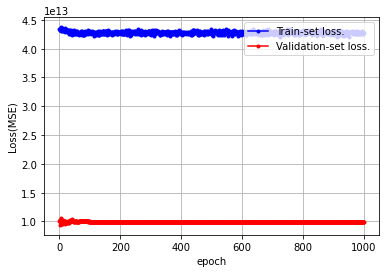

In [196]:
loss = history.history['mean_squared_error']
val_loss = history.history['val_mean_squared_error']

x_len = np.arange(len(loss))

plt.plot(x_len, loss, marker='.', c='blue', label="Train-set loss.")
plt.plot(x_len, val_loss, marker='.', c='red', label="Validation-set loss.")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Loss(MSE)')
plt.show()

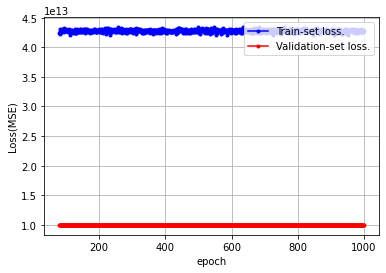

In [197]:
loss = history.history['mean_squared_error']
val_loss = history.history['val_mean_squared_error']

x_len = np.arange(len(loss))

plt.plot(x_len[80:], loss[80:], marker='.', c='blue', label="Train-set loss.")
plt.plot(x_len[80:], val_loss[80:], marker='.', c='red', label="Validation-set loss.")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Loss(MSE)')
plt.show()

# V. WEP & FLASK

FLASK setting

In [ ]:
from flask import Flask
from flask import render_template


In [ ]:
app = Flask(__name__)

FLASK API

In [ ]:
@app.route('/')
def index():
    return render_template("test_out.html")

In [ ]:
from flask import Flask, render_template, request, url_for
@app.route('/valuation', methods=['POST', 'GET'])
def valuation(out=None):
    ## 어떤 http method를 이용해서 전달받았는지를 아는 것이 필요함
    ## 아래에서 보는 바와 같이 어떤 방식으로 넘어왔느냐에 따라서 읽어들이는 방식이 달라짐
    if request.method == 'POST':
        #temp = request.form['num']
        pass
    elif request.method == 'GET':
        ## 넘겨받은 숫자
        busy_day = int(request.args.get('day'))

        ## 넘겨받은 문자
        high_temperature = request.args.get('high')

        Input = pd.DataFrame({
        'busy_day':[int(busy_day)],
        'high_temperature':[float(high_temperature)]
        })
        out = str(model.predict(Input)[0][0])
        ## 넘겨받은 값을 원래 페이지로 리다이렉트
        return render_template('test2out.html', output=out)
    ## else 로 하지 않은 것은 POST, GET 이외에 다른 method로 넘어왔을 때를 구분하기 위함

In [ ]:
app.run(host='0.0.0.0', port=5000)